In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [121]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [31]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [32]:
# We can view all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table
Measurement= Base.classes.measurement
Station = Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
# session = Session(engine)


In [35]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [36]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [47]:
columns = inspector.get_columns('hawaii')
for c in columns:
    print (c['columns'])

# Exploratory Climate Analysis

In [57]:
pd.read_sql("Select * from Station limit 1",conn)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [84]:
pd.read_sql("Select * from Measurement limit 1", conn)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0


In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date =session.query(Measurement.date).order_by(Measurement.date.desc()).first() #2017-08-23
recent_date
# SELECT * from Measurement where date between @2016-08-23 and @2017-08-23 order by date desc

#Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_values = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

prcp_values

# Save the query results as a Pandas DataFrame and  set the index to the datecolumn
prcp_df=pd.DataFrame(prcp_values,columns=["date","prcp"])
prcp_df
# Sort the dataframe by date
prcp_df.set_index("date", inplace=True)
prcp_df = prcp_df.sort_values(by = "date")
prcp_df



2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


Text(0, 0.5, 'Precipitation')

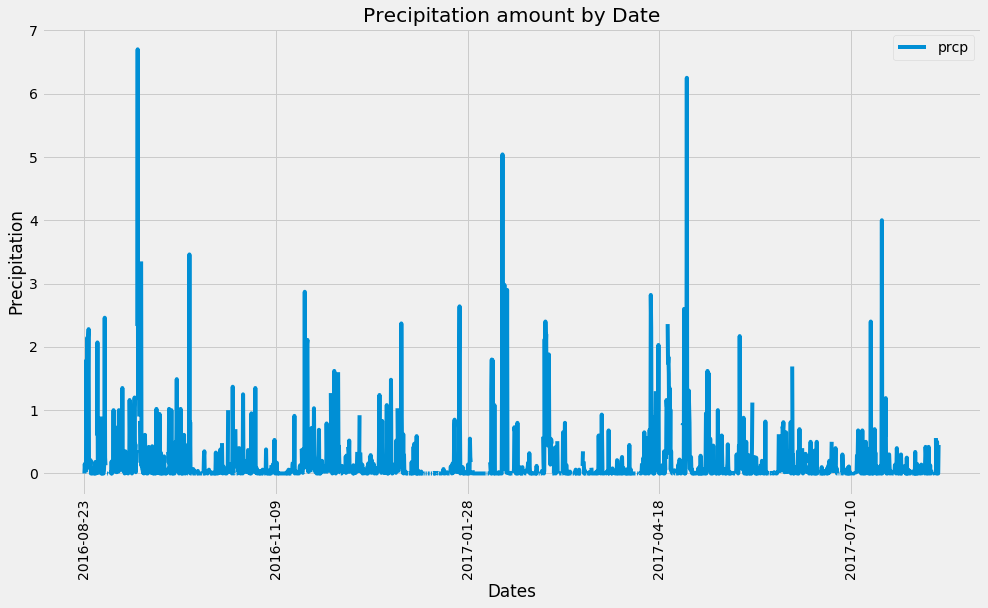

In [99]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90, figsize = (15,8))
plt.title("Precipitation amount by Date")
plt.xlabel("Dates")
plt.ylabel("Precipitation")

In [101]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics= prcp_df.describe()
summary_statistics

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [104]:
# Design a query to show how many stations are available in this datas
station_amount= session.query(func.count(Station.station)).all()
station_amount

[(9)]

In [105]:
# What are the most active stations? (what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [108]:
# Using the station id from the previous query, calculate the 
#lowest temperature recorded, highest temperature recorded,
#and average temperature of the most active station.
station_active = 'USC00519281'
active_station_info= session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
filter(Measurement.station == station_active).all()
active_station_info


[(54.0, 71.66378066378067, 85.0)]

In [111]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station  and plot the results as a histogram
station_temp=session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == station_active).\
filter(Measurement.date >=year_ago).all()
station_temp

[('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 73.0),
 ('USC00519281', 74.0),
 ('USC00519281', 80.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 76.0),
 ('USC00519281', 79.0),
 ('USC00519281', 75.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 76.0),
 ('USC00519281', 74.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 79.0),
 ('USC00519281',

In [113]:
station_temp_df=pd.DataFrame(station_temp, columns=["station","temperature"])
station_temp_df

,station,temperature
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


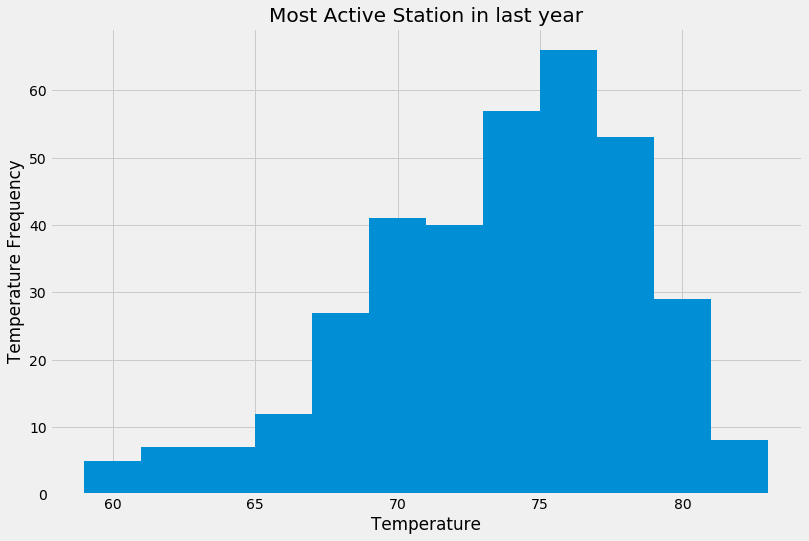

In [119]:
plt.figure(figsize=(12,8))
plt.hist(station_temp_df["temperature"],bins=12)
plt.ylabel("Temperature Frequency")
plt.xlabel("Temperature")
plt.title("Most Active Station in last year")
plt.show()